In [6]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import os
import numpy as np
from keras.applications import InceptionV3
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import cv2

# Read data

In [29]:
x_data = np.load("X.npy")
x_data = np.expand_dims(x_data,axis=3)
X = np.empty((x_data.shape[0], x_data.shape[1], x_data.shape[2], 3))
for i in range(0, x_data.shape[0]):
    X[i] = cv2.cvtColor(x_data[i],cv2.COLOR_GRAY2RGB)
print (X.shape)
    
y = np.load("Y.npy") # from 0 to 19
print (y.shape, len(np.unique(y)), y[:10])

x_test=np.load("X_test.npy")
x_test=np.expand_dims(x_test,axis=3)
X_test = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
for i in range(0, x_test.shape[0]):
    X_test[i] = cv2.cvtColor(x_test[i],cv2.COLOR_GRAY2RGB)
print (X_test.shape)

(660, 168, 308, 3)
(660,) 20 [ 7  5 17 16 11 19  8  3  4 19]
(300, 168, 308, 3)


# Display some images

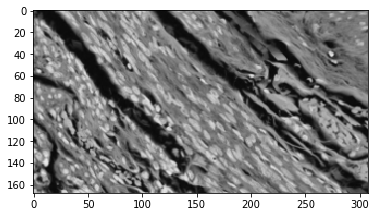

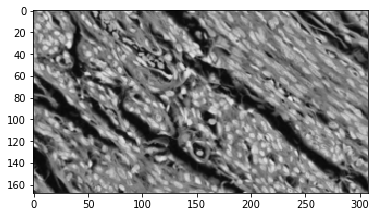

In [31]:
plt.imshow(X[8])
plt.show()

plt.imshow(X_test[0])
plt.show()

# Train

In [32]:
batch_size = 32
epochs = 100
data_augmentation = False

num_classes =  len(np.unique(y))

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

base_model = InceptionV3(weights = 'imagenet', include_top = True, input_tensor = Input(shape=(168,308,3)))

predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.layers[-2].output)

model = Model(inputs = base_model.input, outputs = predictions)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

save_checkpoint = ModelCheckpoint("InceptionV3-epoch{epoch:03d}-val_acc{val_acc:.6f}.hdf5",
            monitor='val_acc',
            verbose=0,  save_best_only=True, save_weights_only=False, mode='max', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=1e-9, epsilon = 0.00001, verbose=1, mode='max')

model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=100,
            validation_data=(x_val, y_val),
            callbacks = [save_checkpoint, reduce_lr],
            shuffle=True)




x_train shape: (528, 168, 308, 3)
528 train samples
132 val samples
Train on 528 samples, validate on 132 samples
Epoch 1/100
528/528 [==============================] - 104s 197ms/step - loss: 1.2634 - acc: 0.6648 - val_loss: 4.5623 - val_acc: 0.3333
Epoch 2/100
528/528 [==============================] - 5s 9ms/step - loss: 0.7516 - acc: 0.7860 - val_loss: 11.7294 - val_acc: 0.0985
Epoch 3/100
528/528 [==============================] - 5s 9ms/step - loss: 0.5946 - acc: 0.8617 - val_loss: 6.2180 - val_acc: 0.3030
Epoch 4/100
528/528 [==============================] - 5s 9ms/step - loss: 0.6966 - acc: 0.8239 - val_loss: 15.7366 - val_acc: 0.0076
Epoch 5/100
528/528 [==============================] - 6s 11ms/step - loss: 0.3315 - acc: 0.9034 - val_loss: 5.9380 - val_acc: 0.3561
Epoch 6/100
528/528 [==============================] - 6s 11ms/step - loss: 0.3140 - acc: 0.9034 - val_loss: 4.7611 - val_acc: 0.4091
Epoch 7/100
528/528 [==============================] - 6s 12ms/step - loss: 0.18

Epoch 59/100
528/528 [==============================] - 6s 12ms/step - loss: 0.0095 - acc: 0.9981 - val_loss: 0.0402 - val_acc: 0.9924
Epoch 60/100
528/528 [==============================] - 5s 10ms/step - loss: 8.6175e-04 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9924
Epoch 61/100
528/528 [==============================] - 5s 9ms/step - loss: 0.0035 - acc: 0.9981 - val_loss: 0.0327 - val_acc: 0.9924
Epoch 62/100
528/528 [==============================] - 5s 10ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9924
Epoch 63/100
528/528 [==============================] - 5s 10ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9848
Epoch 64/100
528/528 [==============================] - 5s 9ms/step - loss: 5.8832e-04 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9848
Epoch 65/100
528/528 [==============================] - 5s 9ms/step - loss: 0.0042 - acc: 0.9981 - val_loss: 0.0453 - val_acc: 0.9848
Epoch 66/100
528/528 [============================

# Predict

In [34]:
%%time

files = ['InceptionV3-epoch061-val_acc0.977273.hdf5',
         'InceptionV3-epoch037-val_acc0.977273.hdf5',
         'InceptionV3-epoch062-val_acc0.984848.hdf5',
         'InceptionV3-epoch059-val_acc0.992424.hdf5']

prediction = np.zeros((300, 20))

# ensemble 
for file in files:
    model = load_model(file, compile = False)
    
    prediction += model.predict(X_test)

# get predictions from probabilities
prediction_class_idx = np.argmax(prediction, axis = 1).reshape(-1,1)

index=np.arange(1,x_test.shape[0]+1).reshape(-1,1)

dat=np.concatenate((index,prediction_class_idx),axis=1)

np.savetxt("preds.csv", dat,"%d,%d",header="Id,Class")

Wall time: 2min 17s
